# IMAGE CLASSIFICATION USING THE FASHION-MNIST DATASET 

In [27]:
# Importing packages and dataset into the workspace
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Exploratory data analysis

Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
(60000, 28, 28)
(10000, 28, 28)


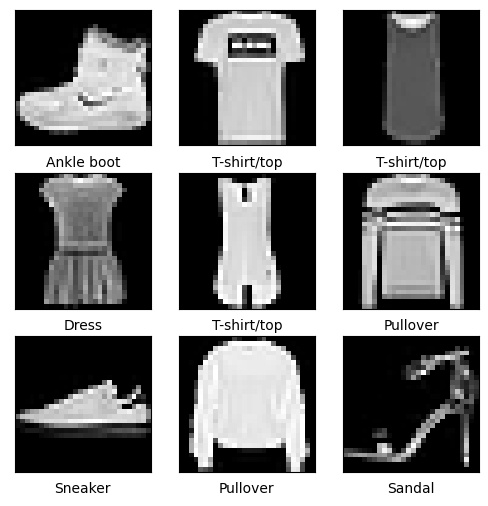

In [40]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


# Getting the dimension of the training and testing sets for images
# and labels. The first value represents the sample size,
# while the next values will represent dimensions of the array.
print(f"Training Images shape: {train_images.shape}")
print(f"Test Images shape: {test_images.shape}")

# We notice that the labels are given without explaining which clothes
# they are supposed to represent. Therefore, we make a list
# that will store the item names
label_names = ['T-shirt/top',
               'Trousers',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

# Now, let us normalize the array values
train_images = train_images/np.float32(255)
test_images = test_images/np.float32(255)

# For classification purposes in python, it will be much better to convert our 2d array into a 1d array, filling in row by row.
# Then we turn our flattened array into a numpy array object. 
def convert(nparray):
    l=[]
    dims=nparray.shape
    for element in range(dims[0]):
        l.append(nparray[element].flatten())
    l=np.array(l)
    return l
train_images_mod = convert(train_images)
test_images_mod  = convert(test_images)

# Before procesing further, let us plot some items and their corresponding classes.
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.gray()
    plt.imshow(train_images[i])
    plt.xlabel(label_names[train_labels[i]])
plt.savefig('./Images/Class-Examples.jpg')
plt.show()

## Dimensionality reduction - Principal Component Analysis

As our data is highly dimensional (784 dimensions), we will resort to the feature selection type of dimensionality reduction,
called principal component analysis. We will calculate first 40 principal components. Then we will make a scree plot, and find
the number of components that we are going to use in our calculations.

## Define the test and training data

In [29]:
# We will first reshape our data, in order to produce viable results. We will choose that our data has 1 channel, which signals
# that we have a grayscale image. The labels will be turned to categorical.

cnn_train       = train_images_mod.reshape(60000,28,28,1)
cnn_test        = test_images_mod.reshape(10000,28,28,1)
cnn_label_train = to_categorical(train_labels)
cnn_label_test  = to_categorical(test_labels)
no_of_epochs    = 5000
batch_size      = 4


# Validation sets

In [30]:
# We will also introduce a validation set. In our case, it will be equal to 16% percent of the training set (closest to 10.000)
# points from the test set

cnn_train, cnn_train_val, cnn_label_train, cnn_label_train_val = train_test_split(cnn_train,cnn_label_train, test_size = 0.16, random_state = 2019)


# Define the model and its layers

In [31]:
# The model we will build is sequential
cnn_model = Sequential()
# First convolution and pooling
cnn_model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu' , kernel_initializer = 'he_uniform', input_shape = (28,28,1), trainable=True))
cnn_model.add(BatchNormalization())

cnn_model.add(MaxPooling2D(pool_size=(1,1), trainable=True))
cnn_model.add(BatchNormalization())

# Second convolution and pooling
cnn_model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', trainable=True))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer
cnn_model.add(Flatten())

# Add dropout
cnn_model.add(Dropout(rate=0.2))

# Dense layers
cnn_model.add(Dense(64,activation = 'relu', trainable=True))
cnn_model.add(BatchNormalization())

# Final layer
cnn_model.add(Dense(10,activation='softmax'))


### Summarise the model




In [32]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 batch_normalization_9 (Batc  (None, 26, 26, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 26, 26, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        9280      
                                                      

## Define learning rate, and compile the model

In [33]:
# Source: https://keras.io/api/optimizers/
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9) # Default values seem to work well


# Compile the model
cnn_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(learning_rate=lr_schedule), # or adam
                  metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

## Train the model
We will also validate the data at the same time

In [34]:
# Here, we are going to fit the model to our dataset.
cnn_model_training = cnn_model.fit(cnn_train,
                                   cnn_label_train,
                                   batch_size=batch_size,
                                   epochs=no_of_epochs,
                                   callbacks=[callback],
                                   verbose=1,
                           validation_data=(cnn_train_val,cnn_label_train_val))

Epoch 1/5000
 7166/12600 [================>.............] - ETA: 47s - loss: 0.6781 - accuracy: 0.7789

KeyboardInterrupt: 

# Plotting accuracies and losses of the CNN

In [ ]:
cnn_accuracy     = cnn_model_training.history['accuracy']
cnn_val_accuracy = cnn_model_training.history['val_accuracy']
loss             = cnn_model_training.history['loss'] 
val_loss         = cnn_model_training.history['val_loss']
epochs = [i for i in range(1, len(cnn_model_training.history['val_loss']) + 1)]

plt.plot(epochs, cnn_accuracy, 'b--', label = 'Test accuracy')
plt.plot(epochs, cnn_val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.savefig('./Graphs/Accuracy values')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b--', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('./Graphs/Loss values')
plt.show()

## Remarks about the model

From the figures above, we see that the model is performing well. We see that the dataset becomes learned around the 15th epoch, because the validation accuracy from the on hovers around 0.915.  We will now evaluate the model on the training set.

In [ ]:
accuracy = cnn_model.evaluate(cnn_test,cnn_label_test,verbose=1)
print('The accuracy of CNN is equal to : ' + str(accuracy[1]))